# Deep Convolutional Generative Adversarial Network using TPU

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop and colab TPUs

### Setup

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.7.0'

In [8]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import datetime
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### added for tpu

In [9]:
# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU@{}'.format(tpu.master()))
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    strategy = tf.distribute.get_strategy()
    
REPLICAS = strategy.num_replicas_in_sync 
print('# REPLICAS: {}'.format(REPLICAS))

Running on TPU@grpc://10.11.40.66:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.11.40.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.40.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# REPLICAS: 8


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [10]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [11]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [12]:
BUFFER_SIZE = 2048
BATCH_SIZE = 128

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE                                    # For accessing data parallelly.
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync              
BS = 128      

In [14]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(2048).batch(BS,drop_remainder=True).prefetch(AUTOTUNE)  

In [15]:
x = train_dataset.unbatch().batch(20)
train_batch = iter(x)
next(train_batch)

<tf.Tensor: shape=(20, 28, 28, 1), dtype=float32, numpy=
array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],

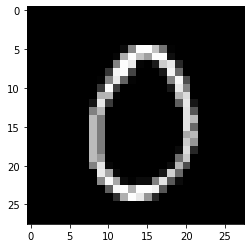

In [16]:
plt.imshow(tf.reshape(next(train_batch)[0, :, :,:], [28,28]), cmap='gray')


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

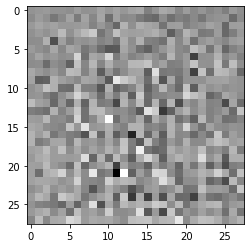

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00099014]], shape=(1, 1), dtype=float32)


### Define losses in TPU

In [ ]:
with strategy.scope():                                                                            # Note, I initialize the loss functions under the strategy's scope
    loss_object = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, 
    reduction= tf.keras.losses.Reduction.NONE)                                                    # Set reduction to `none` so we can do the reduction afterwards and 
                                                                                                  # divide by global batch size/
    
    
    def generator_loss(fake_output):
        per_example_loss =  loss_object(tf.ones_like(fake_output), fake_output)                   # Getting the unscaled loss.
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)  # 'tf.nn.compute_average_loss()' takes the unscaled loss and 
                                                                                                  # GLOBAL_BATCH_SIZE and scale it according to -> 
                                                                                                  # scale_loss = tf.reduce_sum(loss) * (1. / GLOBAL_BATCH_SIZE)
    
    def discriminator_loss(real_output, fake_output):                                             # Same goes for the discriminator_loss
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss  = real_loss + fake_loss
        return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

### Instantiate the Generator and discriminator under the scope for TPU

In [ ]:
with strategy.scope():
    generator = make_generator_model()                                              # Instantiate the Generator and discriminator under the scope!
    discriminator = make_discriminator_model()
    
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)                            # Create the optimizers, here using 2 differnt objects but with same LR
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)     
    
    # checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,       # Create the checkpoint object to store intermediate states of the optimizers and models
    #                              discriminator_optimizer=discriminator_optimizer,
    #                              generator=generator,
    #                              discriminator=discriminator)
    # checkpoint_dir = './training_checkpoints'
    # checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
gen_loss_results = []
disc_loss_results = []
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss_results.append(gen_loss)
      disc_loss_results.append(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
@tf.function
def distributed_train_step(dataset_inputs):
    '''
    Computes per replica losses of a single step and return the scaled losses!
    '''
    # `run` replicates the provided computation and runs it with the distributed input.
    
    per_replica_gloss, per_replica_dloss = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_gloss,axis=None), strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_dloss,axis=None)


def train(dataset, epochs):
    start = time.time()
    for epoch in range(epochs):
        total_loss = 0.0
        gloss = 0.0
        dloss = 0.0
        num_batches = 0
        for image_batch in (dataset):                                                  # Iterate the dataset.
            G, D = distributed_train_step(image_batch)                                 # Get the scaled losses for the generator and discriminator.
            gloss += G                                                                
            dloss += D
            num_batches +=1
            total_loss = gloss+dloss
        
        display.clear_output(wait=True)

        train_loss = total_loss/ num_batches
        gloss = gloss/num_batches
        dloss = dloss/num_batches
        if epoch %15 ==0:
            template = ("Epoch {}\n G-Loss {}\n D-Loss {}\n Train-loss {} \n Time elapsed {}")
            print(template.format(epoch+1, gloss,dloss,train_loss, time.time()-start))
        

**Generate and save images**


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_dataset, EPOCHS)

Epoch 46
 G-Loss 0.943254828453064
 D-Loss 1.2478402853012085
 Train-loss 2.1910951137542725 
 Time elapsed 298.02968192100525


Restore the latest checkpoint.

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

tf.Tensor([[-1.0455761]], shape=(1, 1), dtype=float32)


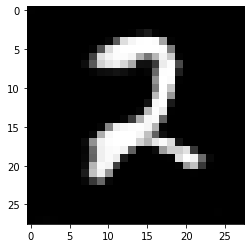

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# plt.imshow(tf.reshape(generated_image[0, :, :,:], [28,28]), cmap='hot')
plt.imshow(generated_image[0, :, :,0], cmap='gray')


decision = discriminator(generated_image)
print(decision)

Use `imageio` to create an animated gif using the images saved during training.